# Import packages

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from read_emg import *


### Plotting parameters 
plt.style.use('seaborn-bright')
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['axes.labelsize'] = 16
pd.options.display.float_format = "{:,.3f}".format


### Supress warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Read Dataset

In [20]:
# %%time
# df = read_file()
# df.to_pickle('DataCollection.pkl')

df = pd.read_pickle('DataCollection.pkl')
df['Trial_num'] = df['Trial_num'].astype(int)
Gesture_list = ['Fist', 'Finger mass extension', 'Opposition', 'Wrist and finger extension']

# Transfer learning (fine-tuning on within session data)

The pretrained model is trained on the dataset: https://github.com/UlysseCoteAllard/MyoArmbandDataset/tree/62b886fc7014aeb81af65d77affedadf40de684c
<br>

- The original gestures (output classes) in the source dataset are: 

    0 = Neutral, 1 = Radial Deviation, 2 = Wrist Flexion, 3 = Ulnar Deviation, 4 = Wrist Extension, 5 = Hand Close, 6 = Hand Open

<br>

- Our target gestures are:

    0 = Fist, 1 = Finger mass extension, 2 = Opposition, 3 = Wrist and finger extension
    
## How the transfer learning is applied

1. The pretrained model will be loaded for every fine tune trial (N = 1)
<br>

2. The last few layers gets removed (Fully connected layers)
<br>

3. Freeze part of the layers so they will not be updated again (features that are extracted from source dataset and will be used directly)
<br>

4. Adds two layers back to adjust for different output classes (7 in the source dataset, 4 in the task dataset)
<br>

5. Compile the model and fit on the fine tune trial (fune-tune training)
<br>

6. After fine tuning, the model is used to predict the test trials (N = 2)
<br>

7. Save the results 

####### Note that fine tune trial and the test trials are in the same session (Within session)

In [89]:
%%time
stats = []
subject_list = ['0100', '0001', '1001', '1002', '1003', '1004', '1005', 
                '1006', '1007', '1008', '1111', '1234', '9999', '9998', 
                '0009', '0010', '0011', '0012']
gesture_list = ['5', '6', '7', '8']

trial_num_list = [1, 2, 3]

### For the classification report 
y_pred_all = []
y_true_all = []
y_pred_proba_all = []

### Iterate through all subjects, sessions and trials 
### Take 1 trial in a session to fine-tune, and test on the other 2 trials

for subject in tqdm(subject_list[:10]):

    for session in ['S1', 'S2']:

        for fine_tune_trial_num in trial_num_list:

            test_trial_num = [x for x in trial_num_list if x != fine_tune_trial_num]
#             print(f'Test trials: {test_trial_num}')
            
            ### fine-tune data from that subject
            df_fine_tune = df[(df['ID'] == subject) & 
                          (df['session'] == session) & 
                          (df['Trial_num'] == fine_tune_trial_num) & 
                          (df['Gesture'].isin(gesture_list))]

            df_test = df[(df['ID'] == subject) & 
                              (df['session'] == session) & 
                              (df['Trial_num'].isin(test_trial_num)) & 
                              (df['Gesture'].isin(gesture_list))]
            
            X_train, y_train, _ = preprocess(df_fine_tune, window_size = 52, nonoverlap_size = 1, highpass = False)
            
            X_test, y_test, _ = preprocess(df_test, window_size = 52, nonoverlap_size = 1, highpass = False)
            
            le = LabelEncoder()
            y_train = le.fit_transform(y_train)
            y_test = le.transform(y_test)   

            y_train = to_categorical(y_train)
            y_test = to_categorical(y_test)
            
            X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1))
            X_test = X_test.reshape((-1, X_test.shape[1], X_test.shape[2], 1))
            
            ### Load pretrained model 
            lastmodel = glob2.glob('save_best_only_v2/*')[-1]
            model_load = load_model(lastmodel)
            
            ### Remove the last 3 layers (two dense and one dropout)
            model_load.pop()
            model_load.pop()
            model_load.pop()
            
            ### Freeze some layers of the neural network
            for layer in model_load.layers[:-7]:
                layer.trainable = False
            
            ### Add layers on top of the pretrained model 
            model_load.add(Dense(64, activation = 'relu', name = 'Dense_2', kernel_regularizer = tf.keras.regularizers.l2(0.03)))
            model_load.add(Dense(4, activation = 'softmax', name = 'out_layer'))
            model_load.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                        loss = tf.keras.losses.CategoricalCrossentropy(),
                        metrics = [tf.keras.metrics.CategoricalAccuracy(name = 'acc')])
            reduce_lr = ReduceLROnPlateau(monitor = 'acc', patience = 3, mode = 'max', verbose = 0)
            early_stopping = EarlyStopping(monitor = 'acc', patience = 10, mode = 'max', verbose = 0)

            history = model_load.fit(X_train, y_train, 
                              callbacks = [reduce_lr, early_stopping], 
                              epochs = 30, verbose = 0, batch_size = 256)
            
            # Get the accuracy before armband calibration
            y_pred = np.argmax(model_load.predict(X_test), axis = -1)
            y_true = np.argmax(y_test, axis = -1)        
            
            y_pred_all.extend(y_pred)
            y_pred_proba_all.extend(model_load.predict(X_test))
            y_true_all.extend(y_true)
            acc = balanced_accuracy_score(y_true, y_pred)

            matrix_before = confusion_matrix(y_true, y_pred)
            cm = pd.DataFrame(matrix_before, columns = Gesture_list, index = Gesture_list)
            cm['ID'] = subject
            cm['session'] = session
#             print(f'Accuracy {acc:.2f}\n')
            #################################################################################################################
            
            stats.append({'ID': subject,
                          'session': session,
                          'Trial_num': test_trial_num,
                          'Accuracy': acc,
                          'confusion_matrix': cm})

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [17:39<00:00, 105.99s/it]

Wall time: 17min 39s


# Balanced accuracy

In [91]:
stats = pd.DataFrame(stats)
stats.to_pickle('stats_transfer_learning_within_session.pkl')

# stats = pd.read_pickle('stats_transfer_learning.pkl')
acc = stats['Accuracy'].mean()
std = stats['Accuracy'].std()
print(f'Accuracy {acc:.2f} +/- {std:.2f}')

Accuracy 0.95 +/- 0.07


## Classification report for multi-class prediction
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [92]:
print(classification_report(y_true_all, y_pred_all, digits = 3, target_names = ['Fist', 'Finger mass extension', 'Opposition', 'Wrist and finger extension']))

                            precision    recall  f1-score   support

                      Fist      0.995     0.947     0.971    108040
     Finger mass extension      0.920     0.935     0.927    108260
                Opposition      0.941     0.948     0.944    108760
Wrist and finger extension      0.931     0.953     0.942    108892

                  accuracy                          0.946    433952
                 macro avg      0.947     0.946     0.946    433952
              weighted avg      0.947     0.946     0.946    433952



# Confusion matrix

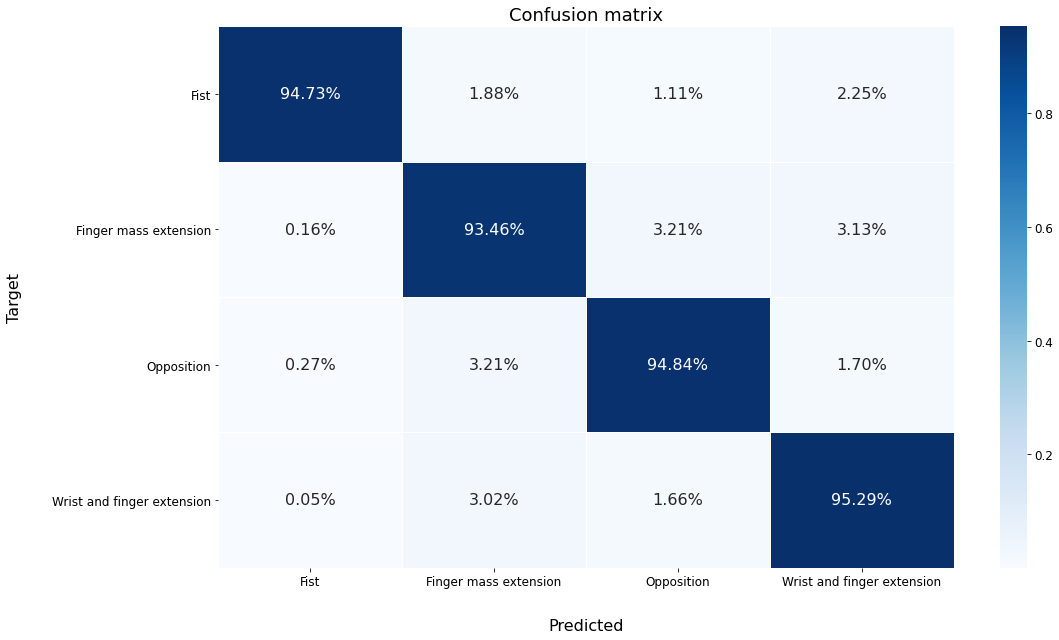

In [103]:
Matrix_1 = stats['confusion_matrix'].sum().iloc[:, :4]
Matrix_1 = Matrix_1 / Matrix_1.astype('float').sum(axis = 1)
Matrix_1 * 100

fig = plt.figure(figsize = (16, 9))
sns.heatmap(Matrix_1, cmap = 'Blues', annot=True, fmt=".2%", linewidths=1.0, annot_kws={"fontsize":16})
plt.title('Confusion matrix', fontsize = 18)
plt.ylabel('Target', labelpad = 30)
plt.xlabel('Predicted', labelpad = 30)
plt.tight_layout()

# Multiclass ROC curve (one versus rest approach)

- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

- https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

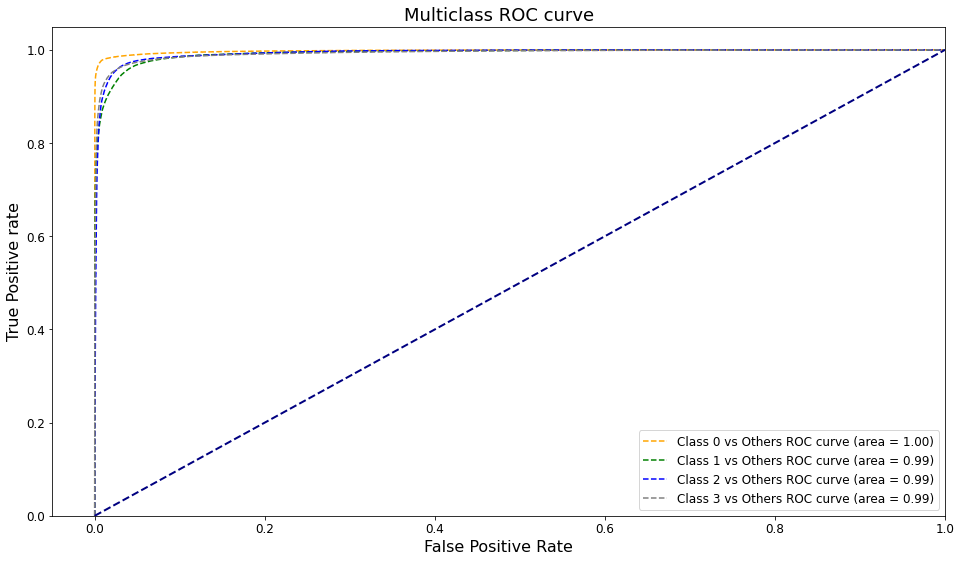

In [105]:
from sklearn.metrics import roc_curve, auc
pred_prob = y_pred_proba_all
y_test = y_true_all
# roc curve for classes
fpr = {}
tpr = {}
roc_auc = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.array(y_test), np.array(pred_prob)[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting  
plt.figure(figsize = (16, 9))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Others ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Others ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Others ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='grey', label='Class 3 vs Others ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Multiclass ROC curve', fontsize =18)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

# Transfer learning (fine-tuning on inter-session data)

In [106]:
def data_augmentation(df, shift_list):
    df_all = df.copy()
    df_flipped = flipping_sensor(df_all)
    df_flipped['Trial_num'] = df_flipped['Trial_num'] + 3
    df_all = pd.concat((df_all, df_flipped), axis = 0)
    count = 2
    for flipped in [False, True]:
        if flipped == True:
            df = flipping_sensor(df)
        for shift in shift_list:
            df_temp = df.iloc[:, :8]
            df_shift = pd.concat((df_temp, df_temp, df_temp), axis = 1).iloc[:, 8 + shift: 16 + shift].values
            df_shift = pd.DataFrame(df_shift, columns = df_temp.columns, index = df.index)
            df_shift = pd.concat((df_shift, df.iloc[:, 8:]), axis = 1)
            df_shift['Trial_num'] = df_shift['Trial_num'] + 3*count
            count +=1
            
            df_all = pd.concat((df_all, df_shift), axis = 0)
        
    return df_all

In [144]:
%%time

stats = []

subject_list = ['0100', '0001', '1001', '1002', '1003', '1004', '1005', 
                '1006', '1007', '1008', '1111', '1234', '9999', '9998', 
                '0009', '0010', '0011', '0012']

### For the classification report 
y_pred_all = []
y_true_all = []
y_pred_proba_all = []

gesture_list = ['5', '6', '7', '8']
session_list = ['S1', 'S2']
for subject in tqdm(subject_list[:10]): 

    for session_test in session_list:
        
        session_train = [x for x in session_list if x != session_test]
        session_reference = session_train[0]
        
        df_train_calibrated_all = df[(df['ID'] == subject) & 
                                     (df['session'] == session_reference) & 
                                     (df['Trial_num'] <=3) & 
                                     (df['Gesture'].isin((gesture_list)))]
        
#         print('\n===========================================')
#         print(f'Data augmentation for training data.....')
#         print('===========================================')
        
        df_train_calibrated_all = data_augmentation(df_train_calibrated_all, shift_list = [-3, -2, -1, 1, 2, 3, 4])
        
        for session_train_to_augment in session_train[1:]:

            df_train_calibrated = df[(df['ID'] == subject) & 
                                     (df['session'] == session_train_to_augment) & 
                                     (df['Trial_num'] <=3) & 
                                     (df['Gesture'].isin((gesture_list)))]
            
            df_train_calibrated = data_augmentation(df_train_calibrated, shift_list = [-3, -2, -1, 1, 2, 3, 4])
            
            df_train_calibrated_all = pd.concat((df_train_calibrated_all, df_train_calibrated), axis = 0)
             
#         print('\n===========================================')
#         print(f'Read the test data......................')
#         print('===========================================') 
        
        df_test = df[(df['ID'] == subject) & 
                     (df['session'] == session_test) & 
                     (df['Trial_num'] <=3) & 
                     (df['Gesture'].isin((gesture_list)))]
            
        df_train = df_train_calibrated_all.copy()
        df_test = df_test.copy()

#         print(f'Data preprocessing and filtering\n')
        X_train, y_train, _= preprocess(df_train, window_size = 52, nonoverlap_size = 5, highpass = False)

        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_train = to_categorical(y_train)
        X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1))
        
        ### Load pretrained model 
        lastmodel = glob2.glob('save_best_only_v2/*')[-1]
        model_load = load_model(lastmodel)

        ### Remove the last 3 layers (two dense and one dropout)
        model_load.pop()
        model_load.pop()
        model_load.pop()

        ### Freeze some layers of the neural network
        for layer in model_load.layers[:-7]:
            layer.trainable = False

        ### Add layers on top of the pretrained model 
        model_load.add(Dense(64, activation = 'relu', name = 'Dense_2'))
        model_load.add(Dense(32, activation = 'relu', name = 'Dense_3'))
        model_load.add(Dense(4, activation = 'softmax', name = 'out_layer'))
        model_load.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                    loss = tf.keras.losses.CategoricalCrossentropy(),
                    metrics = [tf.keras.metrics.CategoricalAccuracy(name = 'acc')])
        reduce_lr = ReduceLROnPlateau(monitor = 'acc', patience = 3, mode = 'max', verbose = 0)
        early_stopping = EarlyStopping(monitor = 'acc', patience = 5, mode = 'max', verbose = 0)

        history = model_load.fit(X_train, y_train, 
                          callbacks = [reduce_lr, early_stopping], 
                          epochs = 100, verbose = 0, batch_size = 256)        
        
        ########################## Add code to cross validate 3 trials 

        for trial_num in [1, 2, 3]:
            X_test, y_test, _= preprocess(df_test[df_test['Trial_num'] == trial_num], 
                                          window_size = 52, 
                                          nonoverlap_size = 1, 
                                          highpass = False)


            y_test = le.transform(y_test)
            y_test = to_categorical(y_test)

            X_test = X_test.reshape((-1, X_test.shape[1], X_test.shape[2], 1))

            # Get the accuracy before armband calibration
            y_pred = np.argmax(model_load.predict(X_test, batch_size = 1), axis = -1)
            y_true = np.argmax(y_test, axis = -1)        
            acc = balanced_accuracy_score(y_true, y_pred)
            
            y_pred_all.extend(y_pred)
            y_pred_proba_all.extend(model_load.predict(X_test))
            y_true_all.extend(y_true)

            matrix_before = confusion_matrix(y_true, y_pred)
            cm_before = pd.DataFrame(matrix_before, columns = Gesture_list, index = Gesture_list)
            cm_before['ID'] = subject
            cm_before['session'] = session_test
#             print(f'Accuracy: {acc:.3f}')

            stats.append({'ID': subject,
                          'session': session_test,
                          'Trial_num': trial_num,
                          'Accuracy_with_data_augmentation': acc,
                          'confusion_matrix': cm_before})

100%|████████████████████████████████████████████████████████████████████████████| 10/10 [1:13:18<00:00, 439.85s/it]

Wall time: 1h 13min 18s


In [145]:
stats = pd.DataFrame(stats)
stats.to_pickle('stats_transfer_learning_between_session.pkl')

In [146]:
stats.set_index('ID', inplace = True)

In [147]:
acc = stats['Accuracy_with_data_augmentation'].mean()
std = stats['Accuracy_with_data_augmentation'].std()
print(f'Accuracy {acc:.2f} +/- {std:.2f}')

Accuracy 0.76 +/- 0.16


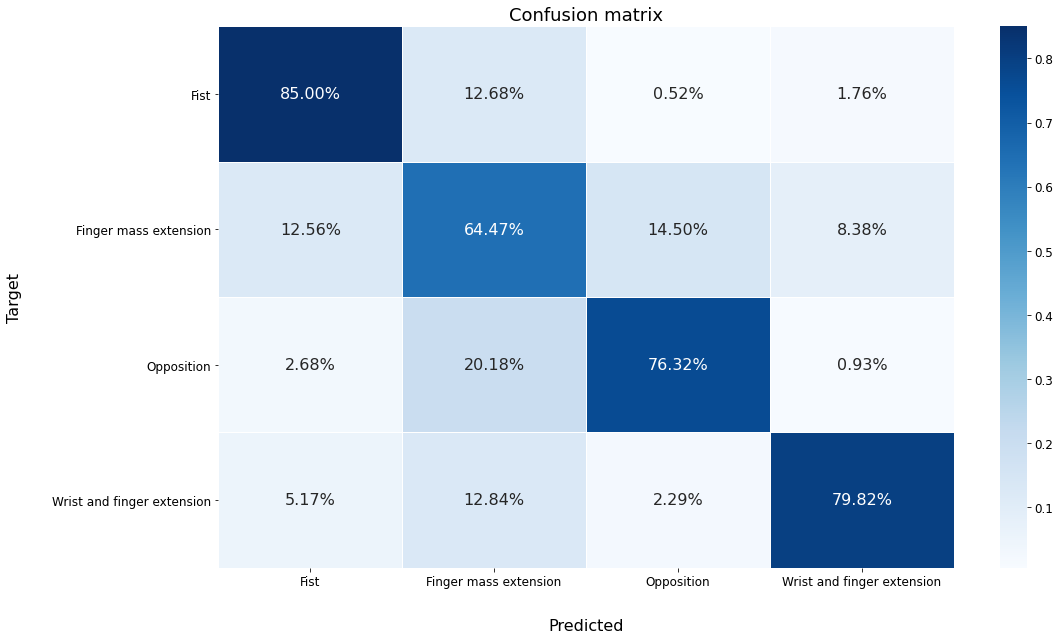

In [148]:
Matrix_1 = stats['confusion_matrix'].sum().iloc[:, :4]
Matrix_1 = Matrix_1 / Matrix_1.astype('float').sum(axis = 1)
Matrix_1 * 100

fig = plt.figure(figsize = (16, 9))
sns.heatmap(Matrix_1, cmap = 'Blues', annot=True, fmt=".2%", linewidths=1.0, annot_kws={"fontsize":16})
plt.title('Confusion matrix', fontsize = 18)
plt.ylabel('Target', labelpad = 30)
plt.xlabel('Predicted', labelpad = 30)
plt.tight_layout()

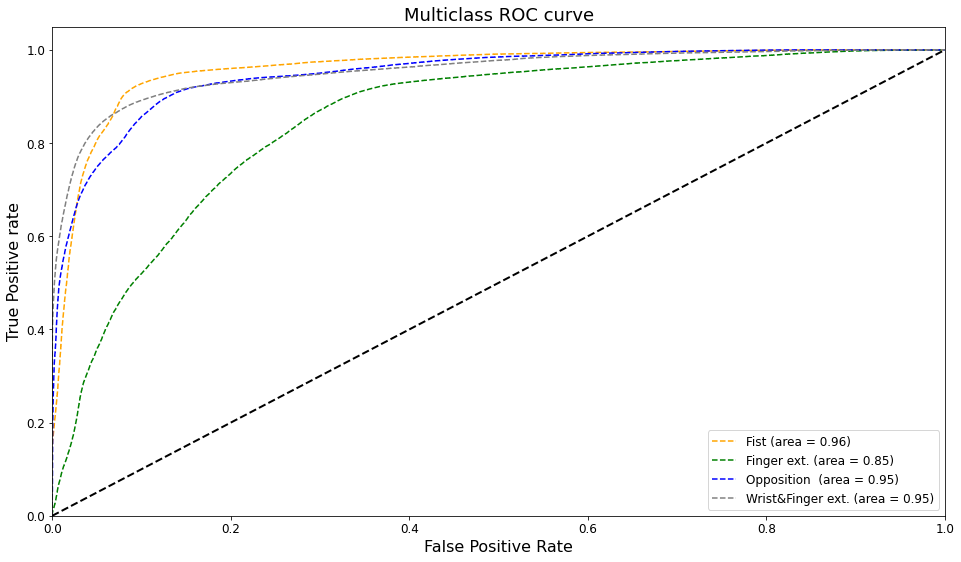

In [150]:
from sklearn.metrics import roc_curve, auc
pred_prob = y_pred_proba_all
y_test = y_true_all
# roc curve for classes
fpr = {}
tpr = {}
roc_auc = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.array(y_test), np.array(pred_prob)[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting  
plt.figure(figsize = (16, 9))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Fist (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Finger ext. (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Opposition  (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='grey', label='Wrist&Finger ext. (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='black', lw = 2, linestyle='--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Multiclass ROC curve', fontsize =18)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')